Import dependencies.  BigDataViewer Vistools is the convenience API that we use to display the results of our experiments and it includes all ImgLib2 related dependencies that we need.  We also import the ImgLib2 bridge to ImageJ, because we want to use ImageJ's API to display ImgLib2 data in this notebook.

In [1]:
%mavenRepo scijava.public https://maven.scijava.org/content/groups/public
%maven sc.fiji:bigdataviewer-vistools:1.0.0-beta-29
%maven net.imglib2:imglib2-ij:2.0.0-beta-46

import bdv.util.*;
import io.github.spencerpark.jupyter.kernel.display.common.*;
import io.github.spencerpark.jupyter.kernel.display.mime.*;
import net.imglib2.img.display.imagej.*;
import net.imglib2.view.*;
import net.imglib2.*;
import net.imglib2.position.FunctionRealRandomAccessible;
import net.imglib2.type.numeric.integer.*;
import net.imglib2.util.Intervals;
import net.imglib2.realtransform.*;

In [2]:
//| code-fold: true

// register renderer for ImgLib2 data and arrays
getKernelInstance().getRenderer().createRegistration(RandomAccessibleInterval.class)
        .preferring(MIMEType.IMAGE_PNG)
        .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
        .register((rai, context) -> Image.renderImage(
                ImageJFunctions.wrap(rai, rai.toString()).getBufferedImage(),
                context));

getKernelInstance().getRenderer().createRegistration(RandomAccessible.class)
        .preferring(MIMEType.IMAGE_PNG)
        .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
        .register((ra, context) -> Image.renderImage(
                ImageJFunctions.wrap(
                        Views.interval(
                                ra,
                                new FinalInterval(
                                        Arrays.copyOf(
                                                new long[]{512, 512},
                                                ra.numDimensions()))),
                        ra.toString()).getBufferedImage(),
                context));

getKernelInstance().getRenderer().createRegistration(RealRandomAccessible.class)
        .preferring(MIMEType.IMAGE_PNG)
        .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
        .register((rra, context) -> Image.renderImage(
                ImageJFunctions.wrap(
                        Views.interval(
                                Views.raster(rra),
                                new FinalInterval(
                                        Arrays.copyOf(
                                                new long[]{512, 512},
                                                rra.numDimensions()))),
                        rra.toString()).getBufferedImage(),
                context));

We define the Juliaset as a function in 2D real space using a `BiConsumer` lambda.  The `BiConsumer` receives two parameters, the first one (x) is the 2D coordinate, the second one (y) is the target of the function whose value will be set in place, here we use an `IntType`.  We also have to provide a `Supplier` for instances of the target such that multiple threads can each create their own.

In [3]:
var juliaset = new FunctionRealRandomAccessible<>(
    2,
    (x, fx) -> {
        int i = 0;
        double v = 0, c = x.getDoublePosition(0), d = x.getDoublePosition(1);
        for (; i < 255 && v < 4096; ++i) {
            final double e = c * c - d * d;
            d = 2 * c * d;
            c = e + 0.3;
            d += 0.6;
            v = Math.sqrt(c * c + d * d);
            ++i;
        }
        fx.set(i);
    },
    UnsignedByteType::new);

Now we show this function with BigDataViewer.  Use your mouse and keyboard to zoom in until you reach the precision limit of `double`.

In [4]:
BdvFunctions.show(
    juliaset,
    Intervals.createMinMax(-1, -1, 1, 1),
    "bla",
    BdvOptions.options().is2D()).setDisplayRange(0, 127);

We can also render a snapshot into this notebook.

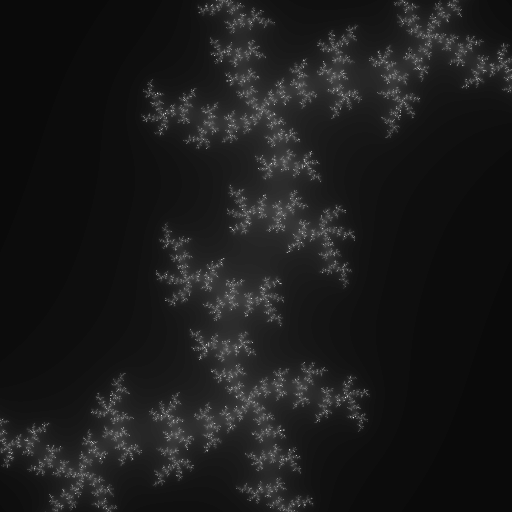

In [5]:
var transform = new ScaleAndTranslation(new double[]{255, 255}, new double[]{255, 255});
var transformed = RealViews.affineReal(juliaset, transform);
transformed;

Cool?  I think so!  Now let's embed one of the two parameters of the Juliaset as a third dimension.  The code is almost the same except that we introduce a a variable a.

In [6]:
var juliaset3 = new FunctionRealRandomAccessible<>(
    3,
    (x, fx) -> {
        int i = 0;
        double v = 0, c = x.getDoublePosition(0), d = x.getDoublePosition(1), a = x.getDoublePosition(2);
        for (; i < 255 && v < 4096; ++i) {
            final double e = c * c - d * d;
            d = 2 * c * d;
            c = e + a;
            d += 0.6;
            v = Math.sqrt(c * c + d * d);
            ++i;
        }
        fx.set(i);
    },
    IntType::new);

And now we show this as a 3D volume in BigDataViewer.  You can scroll through the 'z'-dimension or arbitrarily slice through the 3D volume.

In [7]:
BdvFunctions.show(
    juliaset3,
    Intervals.createMinMax(-1, -1, -1, 1, 1, 1),
    "Juliaset3",
    BdvOptions.options()).setDisplayRange(0, 127);

This was using a stateless function, i.e. each `RealRandomAccess` uses the same instance.  If you have stateful functions, you want to use a function provider.  Spot the difference:

In [8]:
final var rnd = new Random();
var juliaset3Stripes = new FunctionRealRandomAccessible<>(
    3,
    () ->
    { 
        final int offset = rnd.nextInt(100);
        return (x, fx) -> {
            int i = 0;
            double v = 0, c = x.getDoublePosition(0), d = x.getDoublePosition(1), a = x.getDoublePosition(2);
            for (; i < 255 && v < 4096; ++i) {
                final double e = c * c - d * d;
                d = 2 * c * d;
                c = e + a;
                d += 0.6;
                v = Math.sqrt(c * c + d * d);
                ++i;
            }
            fx.set(i + offset);
        };
    },
    IntType::new);

In [9]:
BdvFunctions.show(
    juliaset3Stripes,
    Intervals.createMinMax(-1, -1, -1, 1, 1, 1),
    "Juliaset3",
    BdvOptions.options()).setDisplayRange(0, 127);

We see here, how BigDataViewer uses multiple threads to render each frame, and each thread creates its own independent `RealRandomAccess` to 'access the pixels' (the generator function generates them on the fly).  To visualize this, we add a random number to the pixel values that the generator produces.  This state is unique to the generator of each `RealRandomAccess` and that allows us to see the regions in the output image that are generated by each thread.